# Model Development

This section details the model selection process and initial training procedures.
Navigate: [Previous (Data Preparation)](01_data_preparation.ipynb) | [Next (Feature Engineering)](03_feature_engineering.ipynb)


Distribution of key variables:

Current Mental Health Disorder:
current_disorder
Yes      0.426150
No       0.352704
Maybe    0.221146
Name: proportion, dtype: float64

Sought Treatment:
sought_treatment
1    0.610977
0    0.389023
Name: proportion, dtype: float64

Tech Company Distribution:
is_tech_company
1    0.808717
0    0.191283
Name: proportion, dtype: float64

Gender Distribution:
gender
Male           0.424536
male           0.157385
Female         0.114609
female         0.073446
M              0.058918
                 ...   
cis male       0.000807
Human          0.000807
Genderfluid    0.000807
Enby           0.000807
MALE           0.000807
Name: proportion, Length: 67, dtype: float64

Country Distribution:
country
United States of America    0.677966
United Kingdom              0.145278
Canada                      0.062954
Germany                     0.046812
Netherlands                 0.038741
Australia                   0.028249
Name: proportion, dtype: float64


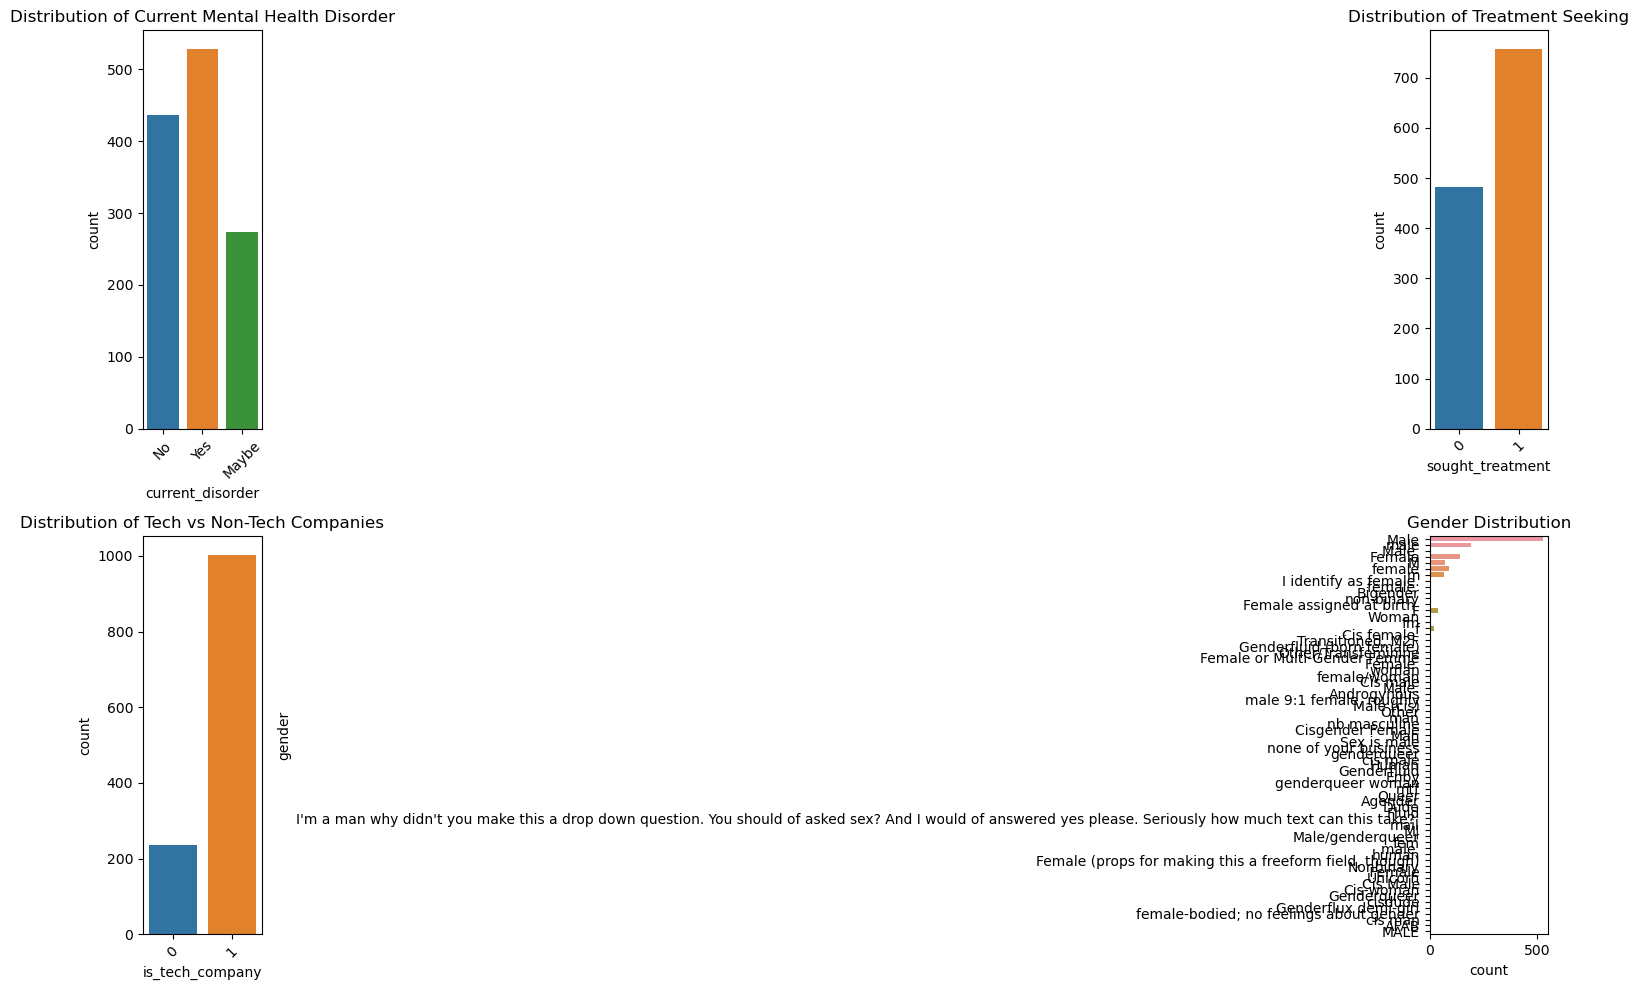


Training set distribution:
sought_treatment
1    0.610494
0    0.389506
Name: proportion, dtype: float64

Test set distribution:
sought_treatment
1    0.612903
0    0.387097
Name: proportion, dtype: float64

Dataset shapes:
X_train: (991, 87)
X_test: (248, 87)
y_train: (991,)
y_test: (248,)


In [1]:
#Splitting to training and testing data
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Connect and get comprehensive data
conn = sqlite3.connect('mental_health_final.db')
query = """
SELECT 
    e.employee_id,
    e.age,
    e.gender,
    e.country,
    emp.company_size,
    emp.is_tech_company,
    emp.work_remotely,
    mhb.has_mental_health_benefits,
    mhh.current_disorder,
    mhh.sought_treatment,
    wc.discuss_with_supervisor
FROM employees e
LEFT JOIN employment emp ON e.employee_id = emp.employee_id
LEFT JOIN mental_health_benefits mhb ON e.employee_id = mhb.employee_id
LEFT JOIN mental_health_history mhh ON e.employee_id = mhh.employee_id
LEFT JOIN workplace_communication wc ON e.employee_id = wc.employee_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

# Explore potential target variables distribution
print("\nDistribution of key variables:")
print("\nCurrent Mental Health Disorder:")
print(df['current_disorder'].value_counts(normalize=True))

print("\nSought Treatment:")
print(df['sought_treatment'].value_counts(normalize=True))

print("\nTech Company Distribution:")
print(df['is_tech_company'].value_counts(normalize=True))

# Check gender distribution
print("\nGender Distribution:")
print(df['gender'].value_counts(normalize=True))

# Check country distribution
print("\nCountry Distribution:")
print(df['country'].value_counts(normalize=True))

# Visualize distributions
plt.figure(figsize=(15, 10))

# Plot 1: Current Disorder Distribution
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='current_disorder')
plt.title('Distribution of Current Mental Health Disorder')
plt.xticks(rotation=45)

# Plot 2: Sought Treatment Distribution
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='sought_treatment')
plt.title('Distribution of Treatment Seeking')
plt.xticks(rotation=45)

# Plot 3: Tech Company Distribution
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='is_tech_company')
plt.title('Distribution of Tech vs Non-Tech Companies')
plt.xticks(rotation=45)

# Plot 4: Gender Distribution
plt.subplot(2, 2, 4)
sns.countplot(data=df, y='gender')
plt.title('Gender Distribution')

plt.tight_layout()
plt.show()

# Based on exploration, we'll use 'sought_treatment' as target variable
# and stratify by this and gender to maintain distributions

# Prepare features and target
X = df.drop(['employee_id', 'sought_treatment'], axis=1)
y = df['sought_treatment']

# Handle categorical variables
categorical_cols = ['gender', 'country', 'company_size', 'work_remotely', 
                   'has_mental_health_benefits', 'current_disorder', 
                   'discuss_with_supervisor']

# Create dummy variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verify stratification
print("\nTraining set distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

# Save the splits
print("\nDataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

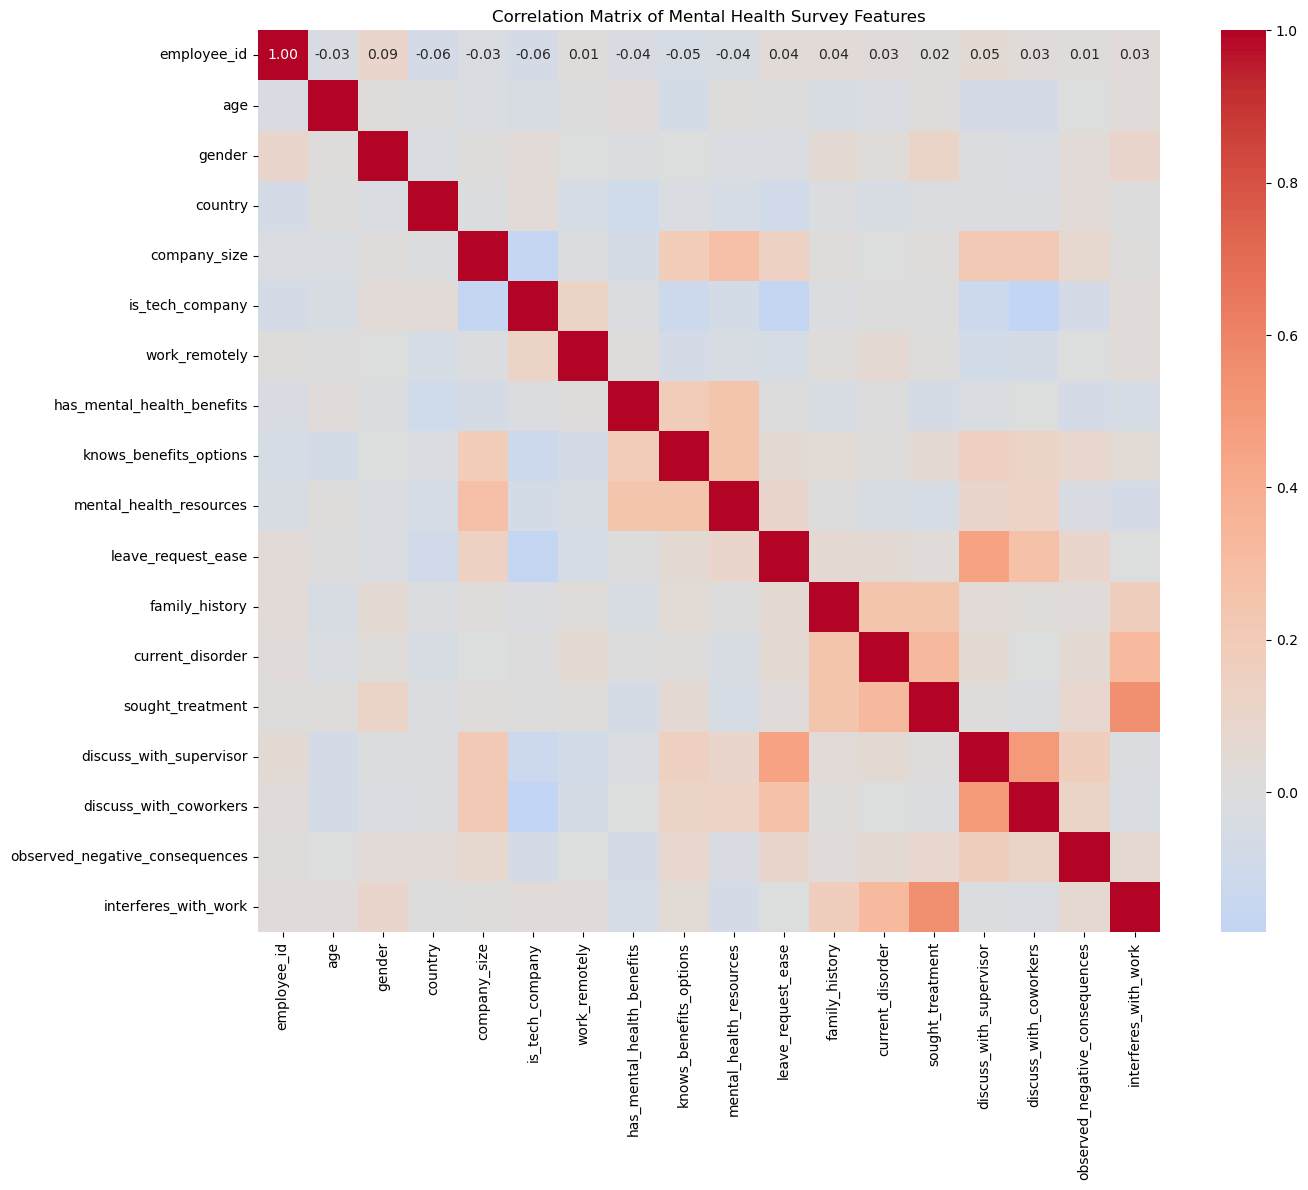


Strongest Feature Correlations:

Top 15 Feature Correlations:
interferes_with_work - sought_treatment: 0.552
discuss_with_coworkers - discuss_with_supervisor: 0.499
discuss_with_supervisor - leave_request_ease: 0.457
sought_treatment - current_disorder: 0.323
interferes_with_work - current_disorder: 0.315
mental_health_resources - company_size: 0.282
discuss_with_coworkers - leave_request_ease: 0.268
current_disorder - family_history: 0.249
mental_health_resources - knows_benefits_options: 0.247
mental_health_resources - has_mental_health_benefits: 0.243
sought_treatment - family_history: 0.242
discuss_with_supervisor - company_size: 0.218
discuss_with_coworkers - company_size: 0.214
knows_benefits_options - has_mental_health_benefits: 0.191
knows_benefits_options - company_size: 0.186

Numerical Variables Summary:
       employee_id          age       gender      country  company_size  \
count    1239.0000  1239.000000  1239.000000  1239.000000   1239.000000   
mean      620.0000    

In [2]:
#Yprofile and correlation matrix
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Get data from database
conn = sqlite3.connect('mental_health_final.db')
query = """
SELECT 
    e.employee_id,
    e.age,
    e.gender,
    e.country,
    emp.company_size,
    emp.is_tech_company,
    emp.work_remotely,
    mhb.has_mental_health_benefits,
    mhb.knows_benefits_options,
    mhb.mental_health_resources,
    mhb.leave_request_ease,
    mhh.family_history,
    mhh.current_disorder,
    mhh.sought_treatment,
    wc.discuss_with_supervisor,
    wc.discuss_with_coworkers,
    wc.observed_negative_consequences,
    wc.interferes_with_work
FROM employees e
LEFT JOIN employment emp ON e.employee_id = emp.employee_id
LEFT JOIN mental_health_benefits mhb ON e.employee_id = mhb.employee_id
LEFT JOIN mental_health_history mhh ON e.employee_id = mhh.employee_id
LEFT JOIN workplace_communication wc ON e.employee_id = wc.employee_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

# Generate YData Profile Report
profile = ProfileReport(df, title="Mental Health Survey Data Profiling Report")
profile.to_file("mental_health_profile_report.html")

# Create correlation matrix
# First, convert categorical variables to numeric
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = pd.factorize(df[col])[0]

# Calculate correlation matrix
correlation_matrix = df.corr()

# Create correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True)
plt.title('Correlation Matrix of Mental Health Survey Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Print strongest correlations
print("\nStrongest Feature Correlations:")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if i != j:
            corr_pairs.append((
                correlation_matrix.index[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

# Sort by absolute correlation value
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print top 15 correlations
print("\nTop 15 Feature Correlations:")
for pair in corr_pairs[:15]:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

# Additional summary statistics for numerical variables
print("\nNumerical Variables Summary:")
print(df.describe())

# Distribution of key categorical variables
print("\nCategorical Variables Distribution:")
for col in categorical_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True))

In [3]:
#Dagshub and MLflow connection
import dagshub
dagshub.init(repo_owner='ashiashish100', repo_name='my-first-repo', mlflow=True)

Accessing as ashiashish100

Initialized MLflow to track repo "ashiashish100/my-first-repo"

Repository ashiashish100/my-first-repo initialized!

In [4]:
#Experiment 1
import sqlite3
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
import logging

# Configure MLflow to track experiments on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/ashiashish100/my-first-repo.mlflow")
mlflow.set_experiment("mental_health_prediction")

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def standardize_gender(df):
    #Standardize gender categories
    df = df.copy()
    # Convert to lowercase
    df['gender'] = df['gender'].str.lower()
    
    # Create mapping for gender standardization
    gender_map = {
        'male': 'male',
        'm': 'male',
        'man': 'male',
        'cis male': 'male',
        'male ': 'male',
        'cisdude': 'male',
        'm|': 'male',
        'female': 'female',
        'f': 'female',
        'woman': 'female',
        'cis female': 'female',
        'female ': 'female'
    }
    
    # Apply mapping and group all other values as 'other'
    df['gender'] = df['gender'].apply(lambda x: gender_map.get(str(x).lower(), 'other'))
    
    return df

def load_and_preprocess_data():
    #Load and preprocess the data
    logger.info("Loading data from database...")
    conn = sqlite3.connect('mental_health_final.db')
    query = """
    SELECT 
        e.age,
        e.gender,
        e.country,
        emp.company_size,
        emp.is_tech_company,
        emp.work_remotely,
        mhb.has_mental_health_benefits,
        mhh.current_disorder,
        mhh.sought_treatment
    FROM employees e
    LEFT JOIN employment emp ON e.employee_id = emp.employee_id
    LEFT JOIN mental_health_benefits mhb ON e.employee_id = mhb.employee_id
    LEFT JOIN mental_health_history mhh ON e.employee_id = mhh.employee_id
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    logger.info("Preprocessing data...")
    # Standardize gender categories
    df = standardize_gender(df)
    
    # Handle NaN values
    df['age'] = df['age'].fillna(df['age'].median())
    df['is_tech_company'] = df['is_tech_company'].fillna(0)
    
    categorical_columns = ['gender', 'country', 'company_size', 'work_remotely', 
                         'has_mental_health_benefits', 'current_disorder']
    
    for col in categorical_columns:
        df[col] = df[col].fillna('unknown')
    
    logger.info(f"Data loaded and preprocessed. Shape: {df.shape}")
    return df

def create_pipeline(scaler_type='standard'):
    #Create preprocessing and model pipeline
    logger.info(f"Creating pipeline with {scaler_type} scaler...")
    
    numeric_features = ['age', 'is_tech_company']
    categorical_features = ['gender', 'country', 'company_size', 'work_remotely', 
                          'has_mental_health_benefits', 'current_disorder']
    
    # Create preprocessing pipelines
    if scaler_type == 'standard':
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
    elif scaler_type == 'minmax':
        numeric_transformer = Pipeline(steps=[
            ('scaler', MinMaxScaler())
        ])
    elif scaler_type == 'log':
        numeric_transformer = Pipeline(steps=[
            ('log', FunctionTransformer(np.log1p)),
            ('scaler', StandardScaler())
        ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create full pipeline
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

def run_experiment(X_train, X_test, y_train, y_test, scaler_type):
    #Run experiment and log results
    logger.info(f"Starting experiment with {scaler_type} scaler...")
    
    with mlflow.start_run(run_name=f"mental_health_{scaler_type}_scaler"):
        # Log parameters
        mlflow.log_param("scaler_type", scaler_type)
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_param("random_state", 42)
        
        # Create and train pipeline
        pipeline = create_pipeline(scaler_type)
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # Log metrics
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        
        # Calculate and log additional metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")
        
        logger.info(f"Experiment with {scaler_type} scaler completed:")
        logger.info(f"F1 Score: {f1:.4f}")
        logger.info(f"Accuracy: {accuracy:.4f}")
        logger.info(f"Precision: {precision:.4f}")
        logger.info(f"Recall: {recall:.4f}")
        logger.info(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
        
        return pipeline, f1

def main():
    try:
        logger.info("Starting mental health prediction experiment...")
        
        # Load and preprocess data
        df = load_and_preprocess_data()
        
        # Prepare features and target
        X = df.drop('sought_treatment', axis=1)
        y = df['sought_treatment']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        logger.info(f"Train set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        # Run experiments with different scalers
        scalers = ['standard', 'minmax', 'log']
        results = {}
        
        for scaler in scalers:
            logger.info(f"\nRunning experiment with {scaler} scaler...")
            pipeline, f1 = run_experiment(X_train, X_test, y_train, y_test, scaler)
            results[scaler] = {'pipeline': pipeline, 'f1_score': f1}
        
        # Print final results
        logger.info("\nFinal Results:")
        for scaler, result in results.items():
            logger.info(f"{scaler} scaler - F1 Score: {result['f1_score']:.4f}")
            
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        raise e

if __name__ == "__main__":
    main()

INFO:__main__:Starting mental health prediction experiment...


INFO:__main__:Loading data from database...


INFO:__main__:Preprocessing data...


INFO:__main__:Data loaded and preprocessed. Shape: (1239, 9)


INFO:__main__:Train set shape: (991, 8)


INFO:__main__:Test set shape: (248, 8)


INFO:__main__:
Running experiment with standard scaler...


INFO:__main__:Starting experiment with standard scaler...


INFO:__main__:Creating pipeline with standard scaler...


C:\Users\ASHISH\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2024/12/21 02:50:52 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.18.0, required: mlflow==2.19.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2024/12/21 02:50:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


INFO:__main__:Experiment with standard scaler completed:


INFO:__main__:F1 Score: 0.7855


INFO:__main__:Accuracy: 0.7379


INFO:__main__:Precision: 0.7881


INFO:__main__:Recall: 0.7829


INFO:__main__:Confusion Matrix: TN=64, FP=32, FN=33, TP=119


🏃 View run mental_health_standard_scaler at: https://dagshub.com/ashiashish100/my-first-repo.mlflow/#/experiments/0/runs/a2452126b7564b868ed766f69e425570
🧪 View experiment at: https://dagshub.com/ashiashish100/my-first-repo.mlflow/#/experiments/0


INFO:__main__:
Running experiment with minmax scaler...


INFO:__main__:Starting experiment with minmax scaler...


INFO:__main__:Creating pipeline with minmax scaler...


C:\Users\ASHISH\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


🏃 View run mental_health_minmax_scaler at: https://dagshub.com/ashiashish100/my-first-repo.mlflow/#/experiments/0/runs/d52995063385421482e4bb835c9b26eb
🧪 View experiment at: https://dagshub.com/ashiashish100/my-first-repo.mlflow/#/experiments/0


In [ ]:
#Experiment 2
import os
import pandas as pd
import numpy as np
import sqlite3
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import logging

# Set DagsHub credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = 'ashiashish100'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '7af28a60cc2f6e231f6413c9b48e241766a2e931'

# MLflow setup
mlflow.set_tracking_uri("https://dagshub.com/ashiashish100/my-first-repo.mlflow")
mlflow.set_experiment("mental_health_multi_classifier")

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def standardize_gender(df):
    """Standardize gender categories"""
    df = df.copy()
    # Convert to lowercase
    df['gender'] = df['gender'].str.lower()
    
    # Create mapping for gender standardization
    gender_map = {
        'male': 'male',
        'm': 'male',
        'man': 'male',
        'cis male': 'male',
        'male ': 'male',
        'cisdude': 'male',
        'm|': 'male',
        'female': 'female',
        'f': 'female',
        'woman': 'female',
        'cis female': 'female',
        'female ': 'female'
    }
    
    # Apply mapping and group all other values as 'other'
    df['gender'] = df['gender'].apply(lambda x: gender_map.get(str(x).lower(), 'other'))
    
    return df

def load_and_preprocess_data():
    logger.info("Loading data from database...")
    conn = sqlite3.connect('mental_health_final.db')
    query = """
    SELECT 
        e.age,
        e.gender,
        e.country,
        emp.company_size,
        emp.is_tech_company,
        emp.work_remotely,
        mhb.has_mental_health_benefits,
        mhh.current_disorder,
        mhh.sought_treatment
    FROM employees e
    LEFT JOIN employment emp ON e.employee_id = emp.employee_id
    LEFT JOIN mental_health_benefits mhb ON e.employee_id = mhb.employee_id
    LEFT JOIN mental_health_history mhh ON e.employee_id = mhh.employee_id
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    logger.info("Preprocessing data...")
    # Standardize gender categories
    df = standardize_gender(df)
    
    # Handle NaN values
    df['age'] = df['age'].fillna(df['age'].median())
    df['is_tech_company'] = df['is_tech_company'].fillna(0)
    
    categorical_columns = ['gender', 'country', 'company_size', 'work_remotely', 
                         'has_mental_health_benefits', 'current_disorder']
    
    for col in categorical_columns:
        df[col] = df[col].fillna('unknown')
    
    logger.info(f"Data loaded and preprocessed. Shape: {df.shape}")
    return df

def create_preprocessing_pipeline():
    #Create preprocessing pipeline
    numeric_features = ['age', 'is_tech_company']
    categorical_features = ['gender', 'country', 'company_size', 'work_remotely', 
                          'has_mental_health_benefits', 'current_disorder']
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    #Evaluate classifier and return metrics
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
    
    return metrics, clf

def run_experiment(classifier, clf_name, preprocessor, X_train, X_test, y_train, y_test):
    #Run experiment for a classifier and log results to MLflow
    with mlflow.start_run(run_name=f"{clf_name}_experiment"):
        # Create and train pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        
        # Log classifier parameters
        params = classifier.get_params()
        for param_name, param_value in params.items():
            mlflow.log_param(param_name, param_value)
        
        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
        
        # Train and evaluate on test set
        metrics, trained_pipeline = evaluate_classifier(pipeline, X_train, X_test, y_train, y_test)
        
        # Log metrics
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(f"test_{metric_name}", metric_value)
        
        # Log model
        mlflow.sklearn.log_model(trained_pipeline, "model")
        
        # Print results
        logger.info(f"\nResults for {clf_name}:")
        logger.info(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        logger.info(f"Test Metrics:")
        for metric_name, metric_value in metrics.items():
            logger.info(f"{metric_name}: {metric_value:.4f}")

def main():
    # Load and preprocess data using the new function
    df = load_and_preprocess_data()
    
    # Prepare features and target
    X = df.drop('sought_treatment', axis=1)
    y = df['sought_treatment']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create preprocessor
    preprocessor = create_preprocessing_pipeline()
    
    # Define classifiers
    classifiers = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'RidgeClassifier': RidgeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }
    
    # Run experiments for each classifier
    for clf_name, classifier in classifiers.items():
        logger.info(f"\nRunning experiment with {clf_name}")
        run_experiment(
            classifier, clf_name, preprocessor, X_train, X_test, y_train, y_test
        )

if __name__ == "__main__":
    main()